In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from Chandra.Time import DateTime
from cxotime import CxoTime
from Ska.engarchive import fetch_eng as fetch
from Ska.Matplotlib import plot_cxctime
import pickle
from pathlib import Path

%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [3]:
if not Path("fss_temps.pkl").exists():
    dat = fetch.Msid("tfssbkt1", "1999:280", stat="daily")
    with open("fss_temps.pkl", "wb") as f:
        pickle.dump(dat, f)
else:
    print("Loading from pickle")
    with open("fss_temps.pkl", "rb") as f:
        dat = pickle.load(f)

Loading from pickle


In [4]:
# yrs = np.arange(2000, 2018)
yrs = np.arange(1999, 2023)
outs = []
outtimes = []
nsamp = 50

for yr in yrs:
    sec0 = DateTime("{}:180".format(yr)).secs
    # sec1 = DateTime('{}:180'.format(yr + 1)).secs
    # sec1 = DateTime('{}:180'.format(yr + 1)).secs
    sec1 = DateTime("{}:060".format(yr + 1)).secs
    i0, i1 = np.searchsorted(dat.times, [sec0, sec1])
    ivals = np.argsort(dat.maxes[i0:i1])
    vals = dat.maxes[i0:i1][ivals]
    times = dat.times[i0:i1][ivals]
    mean_val = np.mean(vals[-nsamp:])
    outs.append(mean_val)
    mean_time = np.mean(times[-nsamp:])
    outtimes.append(mean_time)

outs = np.array(outs)
outtimes = np.array(outtimes)
dates = CxoTime(outtimes)

In [5]:
ftes = Table.read("fte.ecsv")
ftes.info

<Table length=29>
    name     dtype 
----------- -------
       year   int64
   rust-sot float64
   teal-fot float64
   blue-mse float64
   green-ds float64
purple-inst float64
 orange-pub float64
  blue-msfc float64

In [6]:
ylim0 = 0
ylim1 = 120

In [7]:
def rescale(y, y0, y1):
    return (y - y0) / (y1 - y0) * (ylim1 - ylim0) + ylim0

In [8]:
effs = Table.read("fot_mp_mission_efficiency_rolling.csv")
effs["year"] = CxoTime(effs["date"]).frac_year
effs.info

<Table length=1211>
                  name                   dtype     class     n_bad
--------------------------------------- ------- ------------ -----
                                   date   str23       Column     0
               science orbit efficiency float64       Column     0
  rolling mean science orbit efficiency float64 MaskedColumn    52
rolling median science orbit efficiency float64 MaskedColumn    52
                 total observation time float64       Column     0
                     overall efficiency float64       Column     0
                                   year float64       Column     0

In [9]:
ok = ~effs["rolling mean science orbit efficiency"].mask
effs = effs[ok]

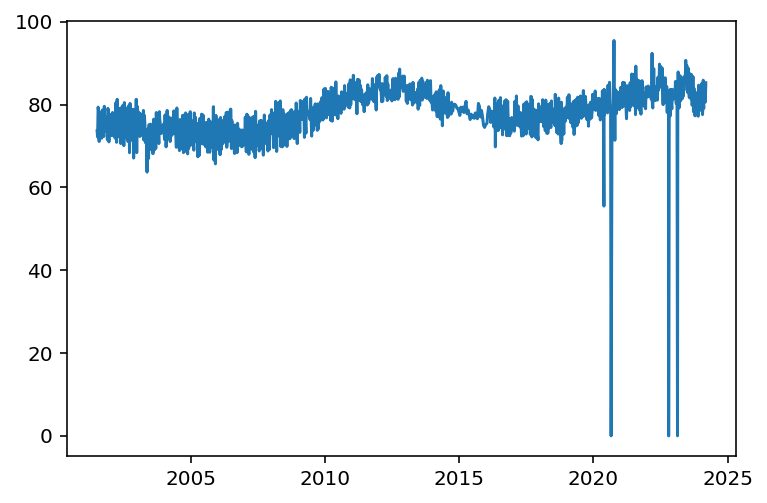

In [10]:
plt.plot(effs["year"], effs["overall efficiency"])

In [11]:
from astropy.convolution import convolve, Box1DKernel

smoothed_effs = effs.copy()
for colname in effs.colnames:
    vals = effs[colname]
    if colname == "overall efficiency":
        smoothed_effs[colname] = convolve(
            effs[colname], Box1DKernel(21), boundary="extend"
        )

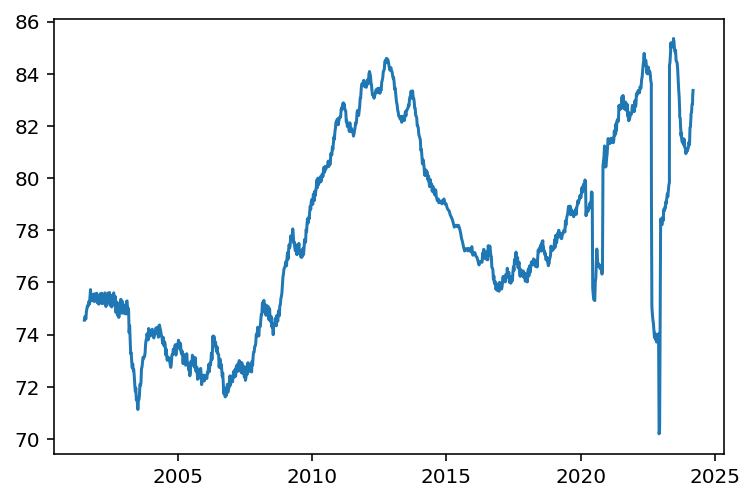

In [12]:
plt.plot(smoothed_effs["year"], smoothed_effs["overall efficiency"])

In [13]:
import functools

rescale_ftes = functools.partial(rescale, y0=0, y1=200)
rescale_fss = functools.partial(rescale, y0=120, y1=240)

In [14]:
def add_events(events, ax, text_y0, text_y1):
    for yr0, yr1, text, color in events:
        text_x = yr1
        ax.plot([yr0, yr1], [text_y0, text_y1], "k--", lw=1)
        ax.text(
            text_x,
            text_y1 + 2,
            text,
            ha="left",
            va="center",
            rotation=90,
            zorder=20,
            rotation_mode="anchor",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.4, pad=2),  # 0.7
            fontsize="medium",
            weight="bold"
            if "Aspect camera dynamic background patch" in text
            else "normal",
            color=color,
        )

In [30]:
def make_plot(events, xmax=2024):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_ylim(0, ylim1)
    ax.set_xlim(2000, xmax)
    ax.plot(
        dates.frac_year,
        rescale_fss(outs),
        "-C0",
        lw=4,
        label="Exterior sun-side Temperature",
    )
    ax.grid(False)
    # ax.margins(0.03)
    # ax.set_xlabel("Year")

    # Add rectangle patch

    # Add text block
    sz_x = 0.7
    text_y0 = 0
    text_y1 = 5

    ok = ftes["year"] < 2022.1
    ax.plot(
        ftes["year"][ok],
        rescale_ftes(ftes["rust-sot"][ok] + ftes["teal-fot"][ok]),
        "-",
        color="C1",
        label="Operations FTEs",
        lw=4,
    )

    ax.plot(
        smoothed_effs["year"],
        smoothed_effs["overall efficiency"],
        "-C2",
        lw=4,
        label="Viewing Efficiency",
    )

    add_events(events, ax, text_y0, text_y1)

    ax.set_yticks([])
    ax.set_ylim(ylim0, ylim1)
    # ax.set_title("Managing Complexity: Hardware Capability Changes")
    xlim0, xlim1 = ax.get_xlim()
    ax.set_xlim(xlim0, xmax)
    ax.plot([0, 0], [0, 0], "-", lw=4, color="r", label="Challenges")
    ax.plot([0, 0], [0, 0], "-", lw=4, color="k", label="Innovations")
    # ax.legend(fontsize="medium", ncols=5, loc="upper left")
    ax.legend(fontsize="medium", loc="upper left")
    plt.savefig("/Users/grant/Desktop/aldcroftplot.pdf", dpi=300)

    plt.show()

In [31]:
hardwares = [
    (2001, 2001, "Grating motion controller microswitch failure"),
    (2003, 2002.5, "Gyro B1 performance degradation; swap sides"),
    (
        2004,
        2004.5,
        "IEPHIN radiation detector degradation\nAdd HRC to radiation monitor",
    ),
    (2009, 2009, "Fuel tank pressure transducer failure"),
    (2013, 2012.0, "FSS-A performance degradation, swap sides"),
    (2013, 2013.0, "MUPS-A performance degradation, swap sides"),
    (2013, 2014.0, "IEPHIN radiation detector failure"),
    (2018, 2018, "Swap to Mixed IRU-1 and 2 configuration"),
    (2020, 2019.5, "Swap to single IRU-2 configuration"),
    (2020, 2020.5, "HRC A-side electronics anomaly, swap sides"),
    (2022, 2021.5, "HRC B-side electronics anomaly, swap sides"),
    (2022, 2022.5, "FSS-A failure"),
]

In [32]:
innovs = [
    (2000, 2000.5, "MATLAB planning tools (through present)"),
    (2001, 2001.25, "Recode grating motion control"),
    (2004, 2004, "Use HRC data in on-board radiation monitor"),
    (2006, 2006, "New on-board propulsion temperature monitor"),
    (2007, 2007, "New gyro calibration technique"),
    (2008, 2008, "New yaw-bias maneuvers in Normal Sun Mode"),
    (2009, 2009, "Momentum parameter firing changes"),
    (
        2011,
        2010.25,
        "Separate science from spacecraft commands\nto dramatically improve safing recovery",
    ),
    (
        2011,
        2011.25,
        "Develop thermal modeling framework\nto manage thermal constraints",
    ),
    (2012, 2012, "Use ACIS data in on-board radiation monitor"),
    (2013, 2013, "Develop flexible momentum cross-strapping"),
    (2015, 2015, "Add diagnostic high-rate telemetry collection"),
    (2016, 2016, "Develop full schedule generation capability\nin MATLAB"),
    (2019, 2018.75, "New star selection and evaluation codes"),
    (2019, 2018.25, "New coarse sun sensor calibration technique"),
    (2020, 2019.5, "Developed TIMBRE for thermal balancing"),
    (2021, 2020.25, "Disabled stuck-on heater for thermal relief"),
    (2022, 2021, "Changed key heater setpoint for thermal relief"),
    (
        2022,
        2021.75,
        "Improved momentum unloading capability",
    ),
    (2023, 2022.5, "Aspect camera dynamic background patch"),
    (2023, 2023.0, "New operations concept to restore HRC science"),
    (2023, 2023.5, "Normal Sun Mode attitude offset patch"),
    # (
    #     2024.4,
    #     2024.4,
    #     "Prevent hot side thruster use for autounloading\n(planned for April 2024)",
    # ),
]

In [33]:
events_red = [vals + ("red",) for vals in hardwares]
events_black = [vals + ("black",) for vals in innovs]
events = sorted(events_red + events_black, key=lambda x: x[1])
events

[(2000, 2000.5, 'MATLAB planning tools (through present)', 'black'),
 (2001, 2001, 'Grating motion controller microswitch failure', 'red'),
 (2001, 2001.25, 'Recode grating motion control', 'black'),
 (2003, 2002.5, 'Gyro B1 performance degradation; swap sides', 'red'),
 (2004, 2004, 'Use HRC data in on-board radiation monitor', 'black'),
 (2004,
  2004.5,
  'IEPHIN radiation detector degradation\nAdd HRC to radiation monitor',
  'red'),
 (2006, 2006, 'New on-board propulsion temperature monitor', 'black'),
 (2007, 2007, 'New gyro calibration technique', 'black'),
 (2008, 2008, 'New yaw-bias maneuvers in Normal Sun Mode', 'black'),
 (2009, 2009, 'Fuel tank pressure transducer failure', 'red'),
 (2009, 2009, 'Momentum parameter firing changes', 'black'),
 (2011,
  2010.25,
  'Separate science from spacecraft commands\nto dramatically improve safing recovery',
  'black'),
 (2011,
  2011.25,
  'Develop thermal modeling framework\nto manage thermal constraints',
  'black'),
 (2013, 2012.0,

In [34]:
events = [
    (2000, 2000.5, "MATLAB planning tools (through present)", "black"),
    (2001, 2001, "Grating motion controller microswitch failure", "red"),
    (2001.25, 2001.5, "Recode grating motion control", "black"),
    (2003, 2003, "Gyro B1 performance degradation; swap sides", "red"),
    (
        2003.9,
        2003.75,
        "IEPHIN radiation detector degradation",
        "red",
    ),
    (2004.1, 2004.25, "Use HRC data in on-board radiation monitor", "black"),
    (2006, 2006, "New on-board propulsion temperature monitor", "black"),
    (2007, 2007, "New gyro calibration technique", "black"),
    (2008, 2008, "New yaw-bias maneuvers in Normal Sun Mode", "black"),
    (2009, 2008.75, "Fuel tank pressure transducer failure", "red"),
    (2009, 2009.25, "Momentum parameter firing changes", "black"),
    (
        2011,
        2010.25,
        "Separate science from spacecraft commands\nto dramatically improve safing recovery",
        "black",
    ),
    (
        2011,
        2011.25,
        "Develop thermal modeling framework\nto manage thermal constraints",
        "black",
    ),
    (2012, 2012.0, "FSS-A performance degradation, swap sides", "red"),
    (2012, 2012.5, "Use ACIS data in on-board radiation monitor", "black"),
    (2013, 2013.0, "MUPS-A performance degradation, swap sides", "red"),
    (2013, 2013.5, "Develop flexible momentum cross-strapping", "black"),
    (2013, 2014.0, "IEPHIN radiation detector failure", "red"),
    (2015, 2015, "Add diagnostic high-rate telemetry collection", "black"),
    (2016, 2016, "Develop full schedule generation capability\nin MATLAB", "black"),
    (2018, 2017.75, "Swap to Mixed IRU-1 and 2 configuration", "red"),
    (2019, 2018.25, "New coarse sun sensor calibration technique", "black"),
    (2019, 2018.75, "New star selection and evaluation codes", "black"),
    (2020, 2019.25, "Swap to single IRU-2 configuration", "red"),
    (2020, 2019.75, "Developed TIMBRE for thermal balancing", "black"),
    (2020, 2020.25, "HRC A-side electronics anomaly, swap sides", "red"),
    (2021, 2020.75, "Disabled stuck-on heater for thermal relief", "black"),
    (2022, 2021.1, "Changed key heater setpoint for thermal relief", "black"),
    (2022, 2021.5, "HRC B-side electronics anomaly", "red"),
    (2022, 2021.85, "Improved momentum unloading capability", "black"),
    (2022, 2022.3, "FSS-A failure", "red"),
    (2023, 2022.6, "Aspect camera dynamic background patch", "black"),
    (2023, 2023.0, "New operations concept to restore HRC science", "black"),
    (2023, 2023.5, "Normal Sun Mode attitude offset patch", "black"),
]

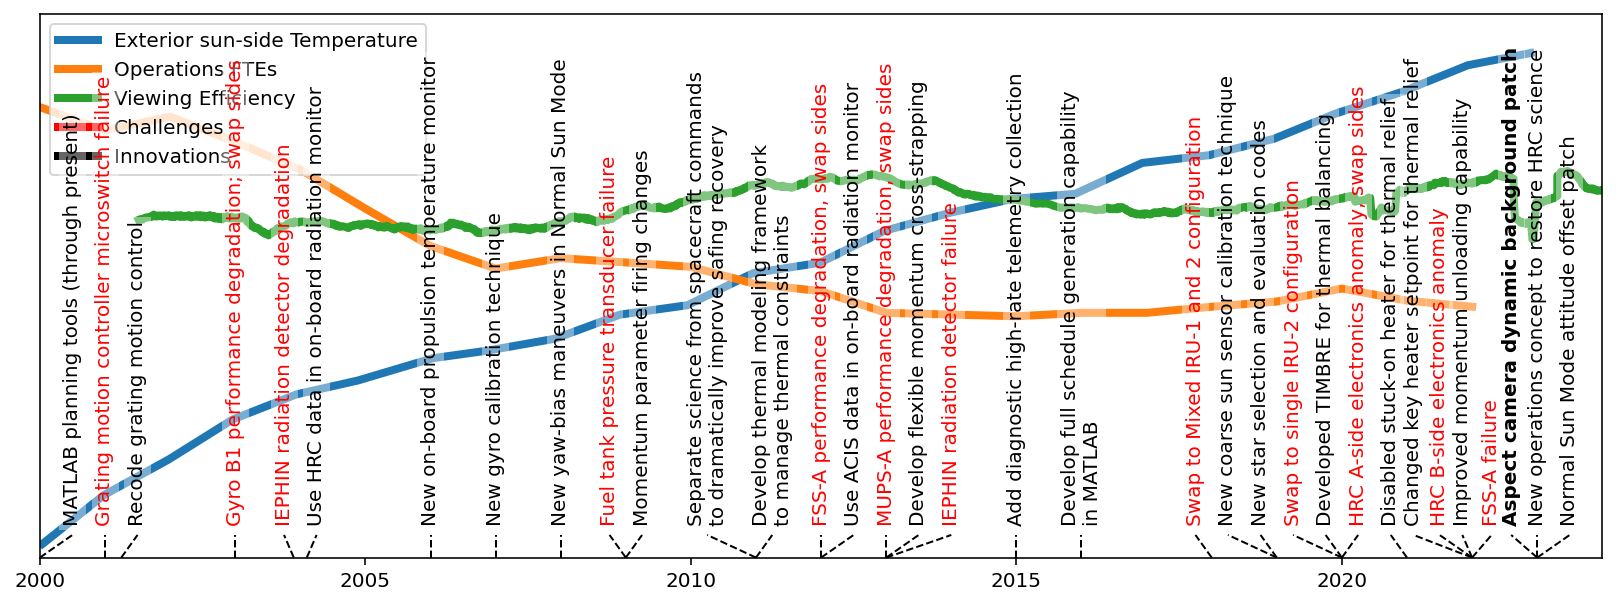

In [35]:
make_plot(events)

In [42]:
ftes["year", "rust-sot", "teal-fot"].pprint_all()

year      rust-sot           teal-fot     
---- ------------------ ------------------
1999  74.72627737226279  73.76824817518249
2000  83.02919708029198  82.70985401459855
2001  86.22262773722629  70.89416058394161
2002   84.3065693430657  77.91970802919708
2003  82.07116788321169  70.89416058394161
2004  75.36496350364963  67.38138686131387
2005  66.10401459854015  62.27189781021898
2006 63.229927007299274  51.41423357664234
2007  56.84306569343066  49.49817518248175
2008 60.675182481751825  49.49817518248175
2009 60.675182481751825 47.901459854014604
2010 60.675182481751825  46.30474452554745
2011  56.52372262773723  44.06934306569343
2012  56.52372262773723  41.51459854014599
2013 48.540145985401466  41.51459854014599
2014 48.540145985401466  40.87591240875913
2015 48.540145985401466 40.237226277372265
2016 48.540145985401466  41.51459854014599
2017 48.540145985401466  41.51459854014599
2018   52.0529197080292 40.237226277372265
2019  53.96897810218979 40.237226277372265
2020 58.120